In [1]:
import math
import numpy as np
import torch
from torch import nn
import d2l

#### 1.生成数据集

In [2]:
max_degree = 20  # 多项式最大阶数

In [3]:
n_train, n_test = 100, 100  # 训练集和测试集数量

In [4]:
# 多项式参数
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

In [5]:
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

In [6]:
features.shape

(200, 1)

In [7]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!

In [8]:
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [9]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]
]

#### 2.对模型进行训练和测试

In [23]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='迭代周期', ylabel='平均损失', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['训练集', '测试集'], figsize=(9, 4.5))
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('预测的权重：', net[0].weight.data.numpy())
    print('真实的权重：', true_w[:4])

#### 3.三阶多项式函数拟合（正常）

预测的权重： [[ 4.9898243  1.2471673 -3.4026828  5.485642 ]]
真实的权重： tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


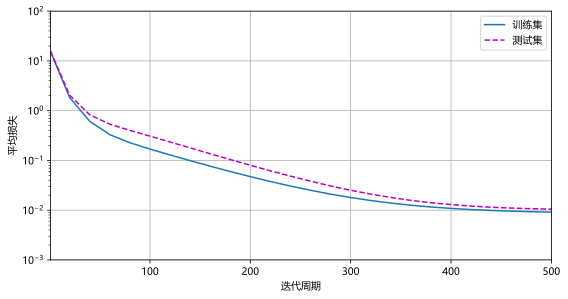

In [24]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:], num_epochs=500)  # 5, 1.2, -3.4, 5.6

#### 4.使用线性（只有x的一阶项）模型拟合（欠拟合）

预测的权重： [[3.61737   2.8848622]]
真实的权重： tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


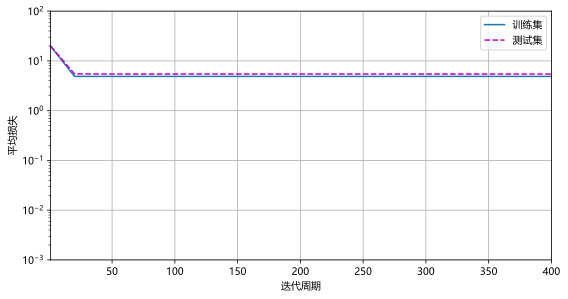

In [25]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

#### 5.使用高阶多项式模型进行拟合

预测的权重： [[ 4.939427    1.2635831  -3.085085    5.1636467  -0.9258886   1.2349167
  -0.26234046 -0.08973614 -0.1939648   0.10368559 -0.03690634  0.00804985
   0.18143904  0.12460332  0.09152821  0.11201479 -0.21754     0.1633772
  -0.14374836  0.21870527]]
真实的权重： tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


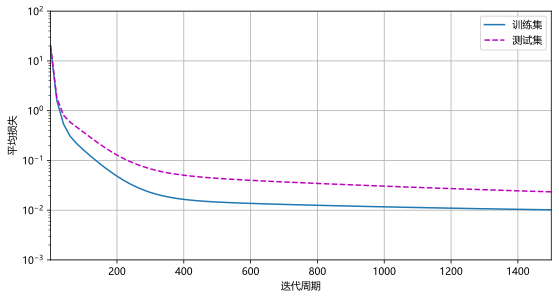

In [28]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)